### Original Source Description

This directory contains the Enron-Spam datasets, as described in the 
paper:

V. Metsis, I. Androutsopoulos and G. Paliouras, "Spam Filtering with 
Naive Bayes - Which Naive Bayes?". Proceedings of the 3rd Conference 
on Email and Anti-Spam (CEAS 2006), Mountain View, CA, USA, 2006.

The "preprocessed" subdirectory contains the messages in the 
preprocessed format that was used in the experiments of the paper.
Each message is in a separate text file. The number at the beginning
of each filename is the "order of arrival".

The "raw" subdirectory contains the messages in their original form. 
Spam messages in non-Latin encodings, ham messages sent by the owners 
of the mailboxes to themselves (sender in "To:", "Cc:", or "Bcc" 
field), and a handful of virus-infected messages have been removed, 
but no other modification has been made. The messages in the "raw" 
subdirectory are more than the corresponding messages in the 
"preprocessed" subdirectory, because: (a) duplicates are preserved 
in the "raw" form, and (b) during the preprocessing, ham and/or spam 
messages were randomly subsampled to obtain the desired ham:spam 
ratios. See the paper for further details.

The Enron-Spam datasets are available from: 
<http://www.iit.demokritos.gr/skel/i-config/> and
<http://www.aueb.gr/users/ion/publications.html>.

The paper is available from:
<http://www.ceas.cc/> and 
<http://www.aueb.gr/users/ion/publications.html>.

V. Metsis, I. Androutsopoulos and G. Paliouras  

This file last updated: June 19, 2006.

### Import all necessary libraries

In [1]:
#Import Standard Libraries
import pandas as pd
import numpy as np
import string, re

#Import Libraries for Plotting Graphs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

#Import NLTK Libraries and Methods for working with Text Data
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize, bigrams

#Import Models We plan to Train for Binary Classification on Text Data
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

#Import transforamtion, Evaluation and Pipeline Methods for building end-to-end ETL Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dilyankovachev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Set Figure Style and Params for Graphs
sns.set_style("dark")
COLOR = 'white'
BACKGROUND_COLOR = '#123456'
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.titlecolor'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.facecolor'] = BACKGROUND_COLOR ## Set background Color
plt.rcParams['figure.facecolor'] = BACKGROUND_COLOR ## Set background Color
plt.rcParams["savefig.facecolor"] = BACKGROUND_COLOR

# Model Findigs Summary

### Below Points Summarize the major findings discovered during our EDA and model testing, exploration and optimization done in this Notebook:

- Combining Content and Subject in one Corpus and training model on that gives us best perfromance, than training model seprately on Content and Subject data
- Lemmatized Corpus works better than Stemmed for all approaches
- Bigrams do not improve performance
- Grid Search did not improve performance on Precision scores, only on Accuracy or Recall
- We want to use Precision as our Model Metric to optimize for, since we want to minimze the number of False Positive, since we do not want to flag important emails as SPAM and move them to SPAM Folder
- Multinomial NB, Logistic Regression, and Random Forest are our Top Performing models in temrs of Precision with 99%, 96% and 97% precision respectively
- Multinomial NB has lowest FP = 11 out of 984 , Random Forest FP = 26 / of 984, Logistic FP = 38 / of 984

### 1. Read CSV Data

In [3]:
email_list = pd.read_csv('email_snorkel.csv')
# charts = pd.read_csv('chart.csv')

In [4]:
email_list.head(3)

,index,subject,content,label
0,0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0
1,1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0
2,17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0


In [5]:
### Combine Subject and Content, so you can train model on combined text
email_list['subj_cont_combined'] = email_list['subject'] + ' ' + email_list['content']

In [6]:
email_list.head()

,index,subject,content,label,subj_cont_combined
0,0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...
1,1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...
2,17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...
3,35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,appeal - democrat daily - inspection about pai...
4,49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,find your fortune in real estate want to be dr...


### 2. Perform some initial EDA and Data Cleaning

In [7]:
email_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33717 entries, 0 to 33716
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               33717 non-null  object 
 1   subject             33426 non-null  object 
 2   content             33345 non-null  object 
 3   label               10092 non-null  float64
 4   subj_cont_combined  33105 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [8]:
email_list.isna().sum()

index                     0
subject                 291
content                 372
label                 23625
subj_cont_combined      612
dtype: int64

In [9]:
email_list.label.value_counts()

1.0    5111
0.0    4981
Name: label, dtype: int64

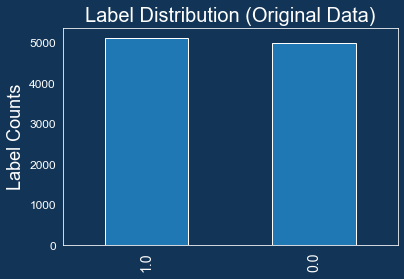

In [10]:
#Label Plot Axes and Title
plt.ylabel('Label Counts', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 12)
plt.title('Label Distribution (Original Data)', fontsize = 20)


#Specify Plot Type
email_list.label.value_counts().plot(kind = 'bar')
plt.show()

In [11]:
# Create Dataframe with Non-NULL labels to be used for model training
model_df = email_list[email_list.label.notnull()]

In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10092 entries, 0 to 33716
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               10092 non-null  object 
 1   subject             9999 non-null   object 
 2   content             9988 non-null   object 
 3   label               10092 non-null  float64
 4   subj_cont_combined  9914 non-null   object 
dtypes: float64(1), object(4)
memory usage: 473.1+ KB


In [13]:
model_df.isna().sum()

index                   0
subject                93
content               104
label                   0
subj_cont_combined    178
dtype: int64

In [14]:
#Drop Rows with NaN values for the combined label
model_df = model_df[model_df.subj_cont_combined.notnull()]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 33716
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               9914 non-null   object 
 1   subject             9914 non-null   object 
 2   content             9914 non-null   object 
 3   label               9914 non-null   float64
 4   subj_cont_combined  9914 non-null   object 
dtypes: float64(1), object(4)
memory usage: 464.7+ KB


In [15]:
model_df.head()

,index,subject,content,label,subj_cont_combined
0,0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...
1,1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...
2,17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...
3,35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,appeal - democrat daily - inspection about pai...
4,49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,find your fortune in real estate want to be dr...


In [16]:
model_df.set_index(['index'], inplace = True)

In [17]:
model_df.head(3)

,subject,content,label,subj_cont_combined
index,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...


### 3. Tokenize, remove punctuation and stopwords and Lemmatize / Stem Text

In [18]:
content = list(model_df.content)
subject = list(model_df.subject)
subj_cont_combined = list(model_df.subj_cont_combined)

In [19]:
#Write Function that tokenizes, cleans and lematizes & stems text data
def clean_docs_lem_stem(text_list):
    #Set initial lists and parameters below before looping and cleaning text
    cleaned_lem = []
    cleaned_stem = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    english = list(set(nltk.corpus.words.words()))
    
    for text in text_list:
        clean_text = nltk.regexp_tokenize(text, pattern)
        text_lower = [i.lower() for i in clean_text]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        text_tokens_stopped = [w for w in text_lower if not w in stopwords_list]
        text_lemmas = [lemmatizer.lemmatize(word) for word in text_tokens_stopped]
        text_stemmas = [stemmer.stem(word) for word in text_tokens_stopped]
        lemmas = " ".join(text_lemmas)
        stems = " ".join(text_stemmas)
        cleaned_lem.append(lemmas)
        cleaned_stem.append(stems)
    return [cleaned_lem, cleaned_stem]

In [20]:
clean_content = clean_docs_lem_stem(content)
clean_subject = clean_docs_lem_stem(subject)
clean_combined = clean_docs_lem_stem(subj_cont_combined)

In [21]:
lemmatized_content = clean_content[0]
lemmatized_subject = clean_subject[0]
lemmatized_combined = clean_combined[0]
stemmed_content = clean_content[1]
stemmed_subject = clean_subject[1]
stemmed_combined = clean_combined[1]

In [22]:
model_df['content_lem'] = lemmatized_content
model_df['subject_lem'] = lemmatized_subject
model_df['combined_lem'] = lemmatized_combined
model_df['content_stem'] = stemmed_content
model_df['subject_stem'] = stemmed_subject
model_df['combined_stem'] = stemmed_combined

In [23]:
model_df.head(3)

,subject,content,label,subj_cont_combined,content_lem,subject_lem,combined_lem,content_stem,subject_stem,combined_stem
index,,,,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...,email loading wise triatomic lauren jocular li...,,email loading wise triatomic lauren jocular li...,email load wise triatom lauren jocular lifo pe...,,email load wise triatom lauren jocular lifo pe...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...,content type text plain charset iso content tr...,lose pound instantly,lose pound instantly content type text plain c...,content type text plain charset iso content tr...,lose pound instant,lose pound instant content type text plain cha...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,meet woman area want f u c k htmlhead headbody...,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k,meet women area want f u c k htmlhead headbody...


In [24]:
#Write function ot add Bigrams to DF
def create_bigrams(text):
    text = bigrams(text.split())
    bigram_lst = ['_'.join(item) for item in list(text)]
    bigrams_combined = ' '.join(bigram_lst)
    
    return bigrams_combined

In [25]:
model_df['combined_lem_bigrams'] = model_df['combined_stem'].apply(create_bigrams)

In [26]:
model_df.head(3)

,subject,content,label,subj_cont_combined,content_lem,subject_lem,combined_lem,content_stem,subject_stem,combined_stem,combined_lem_bigrams
index,,,,,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...,email loading wise triatomic lauren jocular li...,,email loading wise triatomic lauren jocular li...,email load wise triatom lauren jocular lifo pe...,,email load wise triatom lauren jocular lifo pe...,email_load load_wise wise_triatom triatom_laur...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...,content type text plain charset iso content tr...,lose pound instantly,lose pound instantly content type text plain c...,content type text plain charset iso content tr...,lose pound instant,lose pound instant content type text plain cha...,lose_pound pound_instant instant_content conte...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,meet woman area want f u c k htmlhead headbody...,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k,meet women area want f u c k htmlhead headbody...,meet_women women_area area_want want_f f_u u_c...


### 4. Explore Content and Subject WordFreq for positive label

In [27]:
#Etract only SPAM emails, to do some preliminary WordCount EDA on positive label sample
spam_df = model_df[model_df.label == 1.0]
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4950 entries, 0 to 23692
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               4950 non-null   object 
 1   content               4950 non-null   object 
 2   label                 4950 non-null   float64
 3   subj_cont_combined    4950 non-null   object 
 4   content_lem           4950 non-null   object 
 5   subject_lem           4950 non-null   object 
 6   combined_lem          4950 non-null   object 
 7   content_stem          4950 non-null   object 
 8   subject_stem          4950 non-null   object 
 9   combined_stem         4950 non-null   object 
 10  combined_lem_bigrams  4950 non-null   object 
dtypes: float64(1), object(10)
memory usage: 464.1+ KB


In [28]:
spam_df.label.value_counts()

1.0    4950
Name: label, dtype: int64

In [29]:
spam_combined_lem = [nltk.word_tokenize(combined) for combined in list(spam_df.combined_lem)]
spam_combined_lem = list(np.concatenate(spam_combined_lem))
spam_subject_lem = [nltk.word_tokenize(subject) for subject in list(spam_df.subject_lem)]
spam_subject_lem = list(np.concatenate(spam_subject_lem))
spam_comb_bigrams_lem = [nltk.word_tokenize(combined) for combined in list(spam_df.combined_lem_bigrams)]
spam_comb_bigrams_lem = list(np.concatenate(spam_comb_bigrams_lem))

In [30]:
spam_combined_lem[:7]

['email', 'loading', 'wise', 'triatomic', 'lauren', 'jocular', 'lifo']

In [31]:
spam_subject_lem[:7]

['lose', 'pound', 'instantly', 'meet', 'woman', 'area', 'want']

In [32]:
spam_comb_bigrams_lem[:5]

['email_load', 'load_wise', 'wise_triatom', 'triatom_lauren', 'lauren_jocular']

In [33]:
spam_combined_lem_word_count = FreqDist(spam_combined_lem)
spam_subject_lem_word_count = FreqDist(spam_subject_lem)
spam_comb_bigrams_lem_word_count = FreqDist(spam_comb_bigrams_lem)

In [34]:
combined_counts_list = list(spam_combined_lem_word_count.items())
subject_counts_list = list(spam_subject_lem_word_count.items())
bigrams_counts_list = list(spam_comb_bigrams_lem_word_count.items())
combined_sorter_by_freq = sorted(combined_counts_list, key = lambda x: x[1], reverse = True)
subject_sorter_by_freq = sorted(subject_counts_list, key = lambda x: x[1], reverse = True)
bigrams_sorter_by_freq = sorted(bigrams_counts_list, key = lambda x: x[1], reverse = True)
combined_sorter_by_freq[:5]

[('company', 4182), ('com', 3494), ('e', 3073), ('u', 2708), ('http', 2548)]

In [35]:
subject_sorter_by_freq[:5]

[('software', 223),
 ('get', 193),
 ('online', 175),
 ('new', 144),
 ('money', 108)]

In [36]:
bigrams_sorter_by_freq[:5]

[('http_www', 1031),
 ('e_mail', 937),
 ('look_statement', 671),
 ('forward_look', 591),
 ('invest_advic', 453)]

In [37]:
#Write function that plots Top-n labels sorted by values
def plot_sorted_histogram(tup_list, n = 50, title = 'Plot Title', ylabel = 'Y-Axis Label', figsize = (12, 6)):
    #Graph Top-50 Most Frequent Word Token Lemmas Below from Content Corpus
    n = n
    analyze_src = tup_list
    labels = [item[0] for item in analyze_src][:n]
    values = [item[1] for item in analyze_src][:n]

    #Label Plot Axes and Title
    plt.figure(figsize=figsize)
    plt.ylabel(ylabel, fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 90)
    plt.yticks(fontsize = 12)
    plt.title('Top-{} '.format(n) + title, fontsize = 20)

    #Specify Plot Type
    plt.bar(labels,values)
    plt.show()

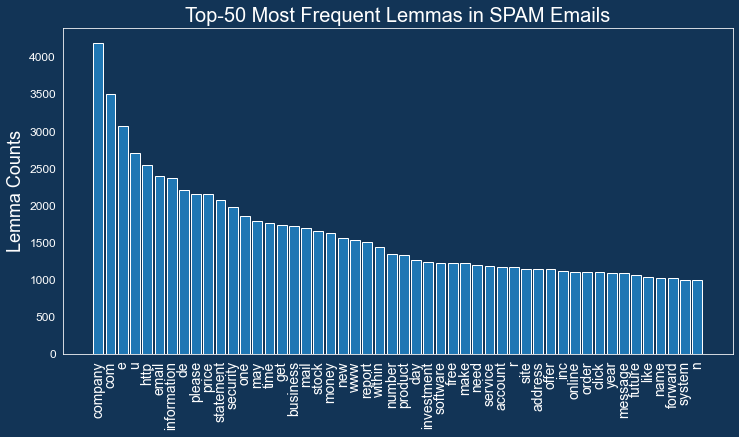

In [38]:
plot_sorted_histogram(combined_sorter_by_freq, 50, 'Most Frequent Lemmas in SPAM Emails', 'Lemma Counts')

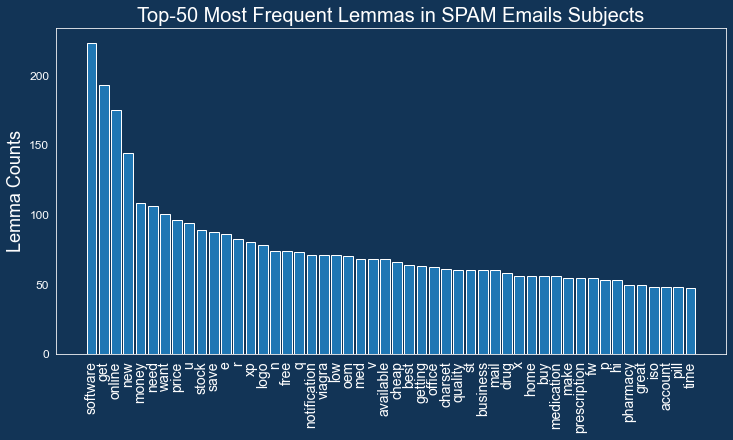

In [39]:
plot_sorted_histogram(subject_sorter_by_freq, 50, 'Most Frequent Lemmas in SPAM Emails Subjects', 'Lemma Counts')

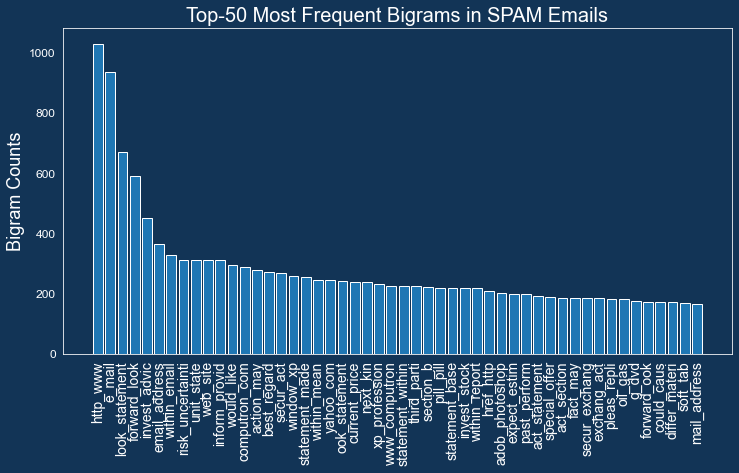

In [40]:
plot_sorted_histogram(bigrams_sorter_by_freq, 50, 'Most Frequent Bigrams in SPAM Emails', 'Bigram Counts')

In [41]:
### Plot same graphs but normalized to total count of tokens
comb_freq_norm = [(item[0], item[1] / len(spam_combined_lem_word_count)) for item in spam_combined_lem_word_count.items()]
subj_freq_norm = [(item[0], item[1] / len(spam_subject_lem_word_count)) for item in spam_subject_lem_word_count.items()]
bigram_freq_norm = [(item[0], item[1] / len(spam_comb_bigrams_lem_word_count)) for item in spam_comb_bigrams_lem_word_count.items()]

In [42]:
sorted_cobined_lems = sorted(comb_freq_norm, key = lambda x: x[1], reverse = True)
sorted_subject_lems = sorted(subj_freq_norm, key = lambda x: x[1], reverse = True)
sorted_bigram_lems = sorted(bigram_freq_norm, key = lambda x: x[1], reverse = True)

In [43]:
sorted_cobined_lems[:3]

[('company', 0.06827643630308076),
 ('com', 0.05704396662911626),
 ('e', 0.050170609459437396)]

In [44]:
sorted_subject_lems[:3]

[('software', 0.03960923623445826),
 ('get', 0.03428063943161634),
 ('online', 0.03108348134991119)]

In [45]:
sorted_bigram_lems[:3]

[('http_www', 0.0036411281493462923),
 ('e_mail', 0.0033091533229267465),
 ('look_statement', 0.002369735197101224)]

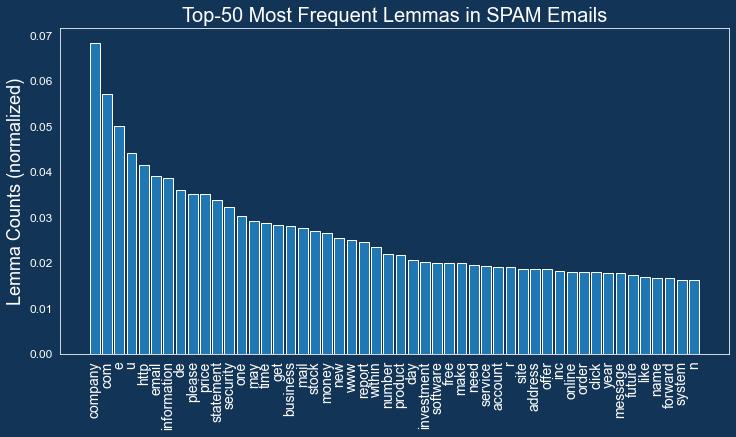

In [46]:
plot_sorted_histogram(sorted_cobined_lems, 50, 'Most Frequent Lemmas in SPAM Emails', 'Lemma Counts (normalized)')

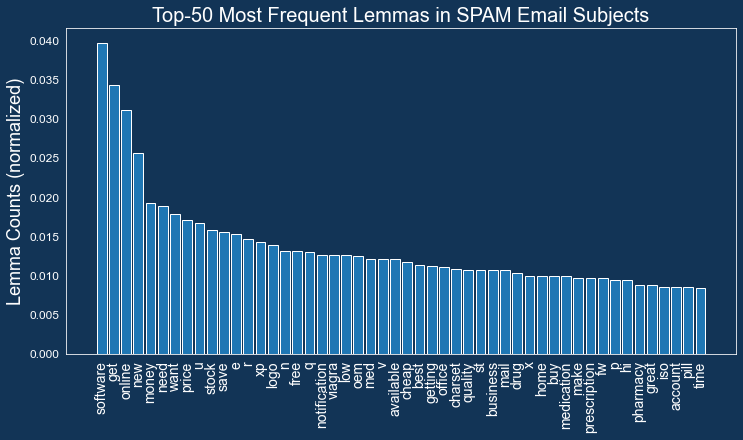

In [47]:
plot_sorted_histogram(sorted_subject_lems, 50, 'Most Frequent Lemmas in SPAM Email Subjects', 'Lemma Counts (normalized)')

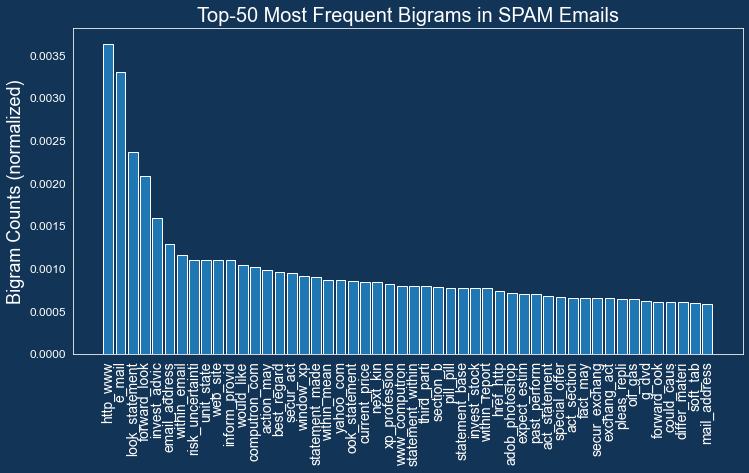

In [48]:
plot_sorted_histogram(sorted_bigram_lems, 50, 'Most Frequent Bigrams in SPAM Emails', 'Bigram Counts (normalized)')

### 5. Train Models with Lemmas and Stems and decide on better approach

### Stemmed Test

In [49]:
model_df.head()

,subject,content,label,subj_cont_combined,content_lem,subject_lem,combined_lem,content_stem,subject_stem,combined_stem,combined_lem_bigrams
index,,,,,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...,email loading wise triatomic lauren jocular li...,,email loading wise triatomic lauren jocular li...,email load wise triatom lauren jocular lifo pe...,,email load wise triatom lauren jocular lifo pe...,email_load load_wise wise_triatom triatom_laur...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...,content type text plain charset iso content tr...,lose pound instantly,lose pound instantly content type text plain c...,content type text plain charset iso content tr...,lose pound instant,lose pound instant content type text plain cha...,lose_pound pound_instant instant_content conte...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,meet woman area want f u c k htmlhead headbody...,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k,meet women area want f u c k htmlhead headbody...,meet_women women_area area_want want_f f_u u_c...
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,appeal - democrat daily - inspection about pai...,n http io com please litterbug boyishdetestati...,appeal democrat daily inspection pain,appeal democrat daily inspection pain n http i...,n http io com pleas litterbug boyishdetest cho...,appeal democrat daili inspect pain,appeal democrat daili inspect pain n http io c...,appeal_democrat democrat_daili daili_inspect i...
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,find your fortune in real estate want to be dr...,want dropped list reply email copy paste link ...,find fortune real estate,find fortune real estate want dropped list rep...,want drop list repli email copi past link brow...,find fortun real estat,find fortun real estat want drop list repli em...,find_fortun fortun_real real_estat estat_want ...


In [50]:
#Define your X and y for model Training
X = model_df.combined_stem
y = model_df.label
len(X) == len(y)

True

In [51]:
#Write Function That Runs Pipeline of Popular Classification Models
def run_model_pipelines(X, y, tokenization = 'Lemmatizer'):
    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
    
    #Built Pipeline of Good Classifier Models
    pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

    pipe_Logistic = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', LogisticRegression())
                    ])

    pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

    pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

    pipe_XGB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', xgb.XGBClassifier())
                    ])

    # List of pipelines, List of pipeline names
    pipelines = [pipe_NB, pipe_Logistic, pipe_RF, pipe_GBoost,  pipe_XGB]
    pipeline_names = ['Multinomail NB', 'Logistic', 'Random Forest', 'Gradient_Boost', "XGBoost"]
    
    
    # Loop to fit each of the pipeline classifiers to Train Data
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)
    
    # Loop trhough each pipe model and print Classification Report and Confusion Matrix
    for index, val in enumerate(pipelines):
        y_test_pred = val.predict(X_test)
        print('-----------------------------------------------------------------------')
        print('Classification Report for Model:  ' + pipeline_names[index] + '({})'.format(tokenization))
        print('-----------------------------------------------------------------------')
        print(classification_report(y_test,  y_test_pred))
        print('----------------------------------------------------------------------')
        print('Confusion Matrix for Model:  ' + pipeline_names[index] + '({})'.format(tokenization))
        print('----------------------------------------------------------------------')

        plot_confusion_matrix(val, X_test, y_test)
        plt.show()

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------------------------
Classification Report for Model:  Multinomail NB(Porter Stemmer Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       999
         1.0       0.99      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB(Porter Stemmer Subject + Content)
---------------

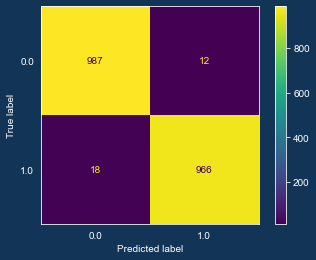

-----------------------------------------------------------------------
Classification Report for Model:  Logistic(Porter Stemmer Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       999
         1.0       0.97      1.00      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Logistic(Porter Stemmer Subject + Content)
----------------------------------------------------------------------


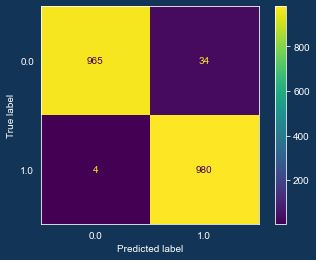

-----------------------------------------------------------------------
Classification Report for Model:  Random Forest(Porter Stemmer Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       999
         1.0       0.97      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Random Forest(Porter Stemmer Subject + Content)
----------------------------------------------------------------------


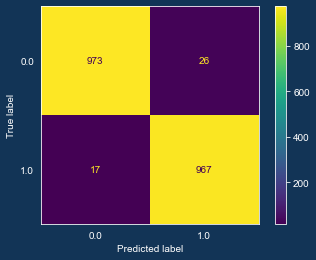

-----------------------------------------------------------------------
Classification Report for Model:  Gradient_Boost(Porter Stemmer Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       999
         1.0       0.93      0.99      0.96       984

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost(Porter Stemmer Subject + Content)
----------------------------------------------------------------------


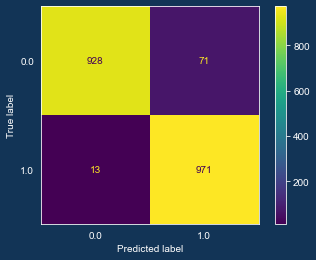

-----------------------------------------------------------------------
Classification Report for Model:  XGBoost(Porter Stemmer Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       999
         1.0       0.95      0.98      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  XGBoost(Porter Stemmer Subject + Content)
----------------------------------------------------------------------


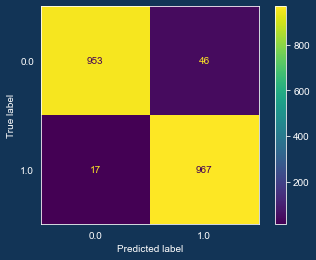

In [52]:
### Run function and analyze performance
run_model_pipelines(X, y, 'Porter Stemmer Subject + Content')

### Lemmatized Test

In [53]:
X = model_df.combined_lem
y = model_df.label
len(X) == len(y)

True

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:05:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------------------------
Classification Report for Model:  Multinomail NB(Lemmatized Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       999
         1.0       0.99      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB(Lemmatized Subject + Content)
-----------------------

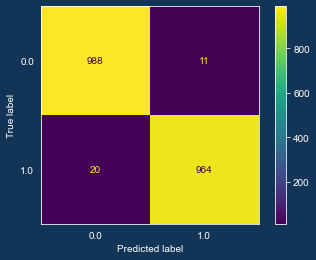

-----------------------------------------------------------------------
Classification Report for Model:  Logistic(Lemmatized Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       999
         1.0       0.96      0.99      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Logistic(Lemmatized Subject + Content)
----------------------------------------------------------------------


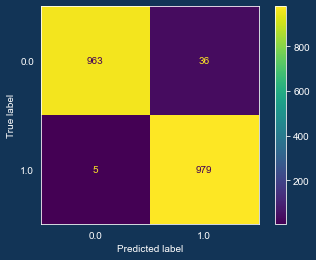

-----------------------------------------------------------------------
Classification Report for Model:  Random Forest(Lemmatized Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       999
         1.0       0.97      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Random Forest(Lemmatized Subject + Content)
----------------------------------------------------------------------


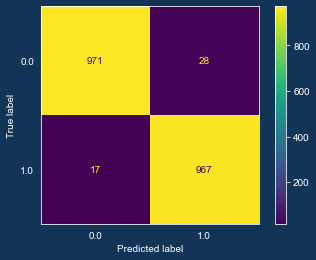

-----------------------------------------------------------------------
Classification Report for Model:  Gradient_Boost(Lemmatized Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       999
         1.0       0.93      0.99      0.96       984

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost(Lemmatized Subject + Content)
----------------------------------------------------------------------


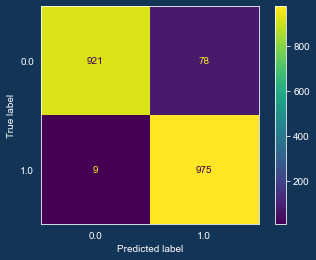

-----------------------------------------------------------------------
Classification Report for Model:  XGBoost(Lemmatized Subject + Content)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       999
         1.0       0.95      0.99      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  XGBoost(Lemmatized Subject + Content)
----------------------------------------------------------------------


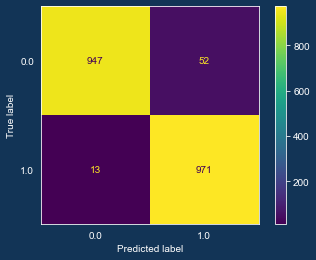

In [54]:
### Run function and analyze performance
run_model_pipelines(X, y, 'Lemmatized Subject + Content')

### Lematized test for Bigrams

In [55]:
X = model_df.combined_lem_bigrams
y = model_df.label
len(X) == len(y)

True

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------------------------
Classification Report for Model:  Multinomail NB(Lemmatizer Bigrams)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       999
         1.0       0.99      0.97      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB(Lemmatizer Bigrams)
-------------------------------------------

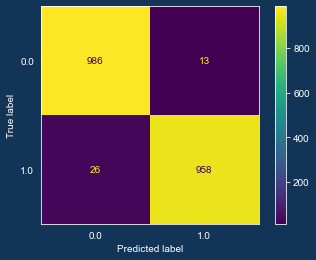

-----------------------------------------------------------------------
Classification Report for Model:  Logistic(Lemmatizer Bigrams)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       999
         1.0       0.93      1.00      0.96       984

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Logistic(Lemmatizer Bigrams)
----------------------------------------------------------------------


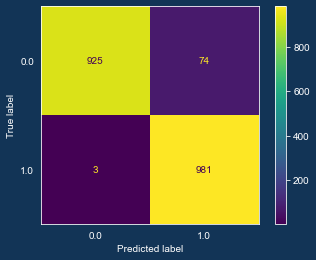

-----------------------------------------------------------------------
Classification Report for Model:  Random Forest(Lemmatizer Bigrams)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93       999
         1.0       0.89      0.99      0.93       984

    accuracy                           0.93      1983
   macro avg       0.94      0.93      0.93      1983
weighted avg       0.94      0.93      0.93      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Random Forest(Lemmatizer Bigrams)
----------------------------------------------------------------------


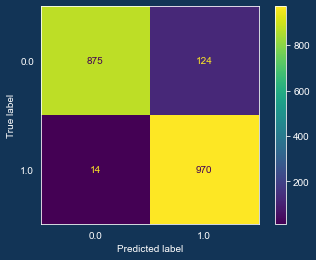

-----------------------------------------------------------------------
Classification Report for Model:  Gradient_Boost(Lemmatizer Bigrams)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.88       999
         1.0       0.83      0.97      0.89       984

    accuracy                           0.89      1983
   macro avg       0.90      0.89      0.88      1983
weighted avg       0.90      0.89      0.88      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost(Lemmatizer Bigrams)
----------------------------------------------------------------------


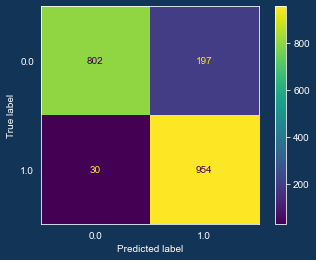

-----------------------------------------------------------------------
Classification Report for Model:  XGBoost(Lemmatizer Bigrams)
-----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       999
         1.0       0.84      0.98      0.91       984

    accuracy                           0.90      1983
   macro avg       0.91      0.90      0.90      1983
weighted avg       0.91      0.90      0.90      1983

----------------------------------------------------------------------
Confusion Matrix for Model:  XGBoost(Lemmatizer Bigrams)
----------------------------------------------------------------------


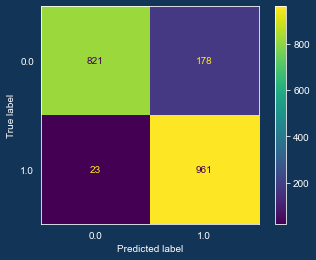

In [56]:
### Run function and analyze performance
run_model_pipelines(X, y, 'Lemmatizer Bigrams')

### Try Using Grid Search
- commented this out since it takes a while to run the GridSearch and I already confirmed it does not improve precision

In [57]:
# X = model_df.combined_lem
# y = model_df.label
# len(X) == len(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# ###Random Forest Grid Search
# GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
#                      ('tfidf_vectorizer', TfidfTransformer()),
#                      ('clf', RandomForestClassifier())
#                     ])

# # sorted(GS_pipe_RF.get_params().keys())

# rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
#                     clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
#                     clf__min_samples_leaf = [3, 6])


# gs_RF = GridSearchCV(estimator=GS_pipe_RF,
#             param_grid=rf_param_grid,
#             scoring='precision',
#             cv=3)

# gs_RF.fit(X_train, y_train)

# # dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
# dt_gs_testing_score = gs_RF.score(X_test, y_test)

# print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))


In [58]:
# y_pred = gs_RF.predict(X_test)
# print('------------------------------------------------------')
# print('Classification Report for Model:  Random Forest')
# print('------------------------------------------------------')
# print(classification_report(y_test,  y_pred))
# print('------------------------------------------------------')
# print('Confusion Matrix for Model:  Random Forest')
# print('------------------------------------------------------')
# plot_confusion_matrix(gs_RF, X_test, y_test)
# plt.show()

### Explore Feature Importances from our Top Models for Interpretability

In [59]:
#Write Function That Runs Pipeline of Top-3 Models and saves models, so we can extract Feature Importances
def run_top_model_pipes(X, y, tokenization = 'Lemmatizer'):
    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
    
    #Built Pipeline of Good Classifier Models
    pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

    pipe_Logistic = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', LogisticRegression())
                    ])

    pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])
    # List of pipelines, List of pipeline names
    pipelines = [pipe_NB, pipe_Logistic, pipe_RF]
    pipeline_names = ['Multinomail NB', 'Logistic Regression', 'Random Forest']
    precision_scores = []
    
    
    # Loop to fit each of the pipeline classifiers to Train Data
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)
    
    # Loop trhough each pipe model and print Classification Report and Confusion Matrix
    for index, val in enumerate(pipelines):
        y_test_pred = val.predict(X_test)
        report = classification_report(y_test,  y_test_pred, output_dict=True)
        precision = report['1.0']['precision']
        precision_scores.append(precision)
        print('---------------------------------------------------------------')
        print('Classification Report for Model:  ' + pipeline_names[index] + '({})'.format(tokenization))
        print('---------------------------------------------------------------')
        print(classification_report(y_test,  y_test_pred))
        print('----------------------------------------------------------------')
        print('Confusion Matrix for Model:  ' + pipeline_names[index] + '({})'.format(tokenization))
        print('----------------------------------------------------------------')

        plot_confusion_matrix(val, X_test, y_test)
        plt.show()
  

    print('----------------------------------------------------------------')
    print('Compare Top 3 Models to Baseline Model (Random Guessing 1.0 Class)')
    print('----------------------------------------------------------------')
    
    #Compare Top Model Precision to baseline Random Guessing Class 1.0 on all
    baseline = round(y_test.value_counts()[1.0] / len(y_test), 3)

    #Label Plot Axes and Title
    plt.ylabel('Precision %', fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 45)
    plt.yticks(fontsize = 12)
    plt.title('Precisions Scores on Label 1.0 = SPAM', fontsize = 20)
    plt.axhline(y=baseline, color='#17CA83', linestyle='-', label = f"Baseline (Random Guessing) = {baseline}")

    #Specify Plot Type
    plt.bar(pipeline_names,precision_scores)
    plt.legend(loc = 4)
    plt.show()
        
    return list(zip(pipeline_names, pipelines))

In [60]:
#Define your X and y for model Training
X = model_df.combined_lem
y = model_df.label
len(X) == len(y)

True

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
---------------------------------------------------------------
Classification Report for Model:  Multinomail NB(Lemmatizer)
---------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       999
         1.0       0.99      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      19

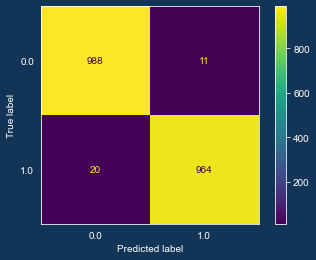

---------------------------------------------------------------
Classification Report for Model:  Logistic Regression(Lemmatizer)
---------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       999
         1.0       0.96      0.99      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------
Confusion Matrix for Model:  Logistic Regression(Lemmatizer)
----------------------------------------------------------------


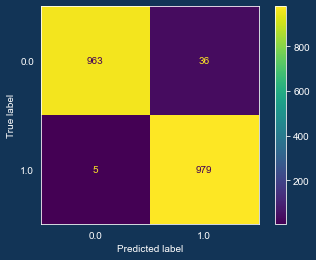

---------------------------------------------------------------
Classification Report for Model:  Random Forest(Lemmatizer)
---------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       999
         1.0       0.97      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

----------------------------------------------------------------
Confusion Matrix for Model:  Random Forest(Lemmatizer)
----------------------------------------------------------------


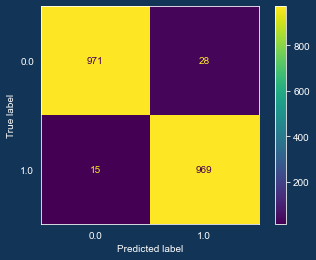

----------------------------------------------------------------
Compare Top 3 Models to Baseline Model (Random Guessing 1.0 Class)
----------------------------------------------------------------


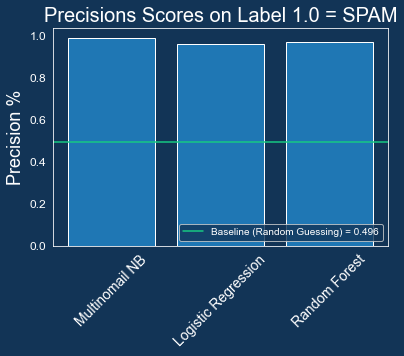

In [61]:
extract_top_models = run_top_model_pipes(X, y, tokenization = 'Lemmatizer')

#### Random Forest

In [64]:
RF_pipe = extract_top_models[2]
RF_pipe

('Random Forest',
 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                 ('tfidf_vectorizer', TfidfTransformer()),
                 ('clf', RandomForestClassifier())]))

In [65]:
#Write Function to Extract Feature Importances
def feat_importances_RF(RF_pipe):
    model_name = RF_pipe[0]
    model = RF_pipe[1]['clf']
    vect = RF_pipe[1]['count_vectorizer']
    columns = list(vect.vocabulary_.keys())
    coefs = model.feature_importances_
    
    col_coefs = list(zip(columns, coefs))
    sorted_importances = sorted(col_coefs, key = lambda x: x[1], reverse = True)
    
    return sorted_importances

In [67]:
sorted_importances_RF = feat_importances_RF(RF_pipe)

In [68]:
sorted_importances_RF[:5]

[('colossal', 0.038807723500801965),
 ('spvdhc', 0.013223274180875827),
 ('rule', 0.012180888249927717),
 ('controis', 0.012159967188001225),
 ('creas', 0.011733303592027133)]

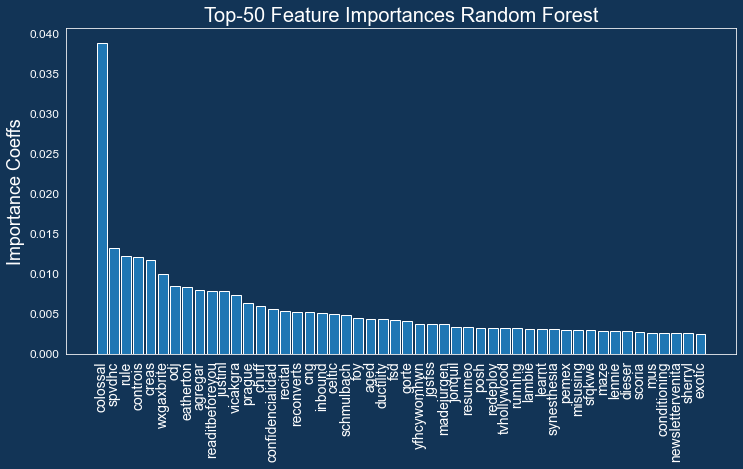

In [69]:
plot_sorted_histogram(sorted_importances_RF, 50, 'Feature Importances Random Forest', 'Importance Coeffs')

#### Multinomial NB

In [70]:
NB_pipe = extract_top_models[0]
NB_pipe

('Multinomail NB',
 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                 ('tfidf_vectorizer', TfidfTransformer()),
                 ('clf', MultinomialNB())]))

In [71]:
#Write Function to Extract Feature Importances
def feat_importances_NB(NB_pipe):
    model_name = NB_pipe[0]
    model = NB_pipe[1]['clf']
    vect = NB_pipe[1]['count_vectorizer']
    
    #Calcualte importances of words in the data as measured by their contribution
    #to the difference in log probabilities between the two Classes
    delta_log_prob = model.feature_log_prob_[1, :] - model.feature_log_prob_[0, :]
    
    #Multiply importance by count of each word in corpus
    vect_data = list(vect.vocabulary_.items())
    columns = [item[0] for item in vect_data]
    word_counts = np.array([item[1] for item in vect_data])
    
    importances = np.multiply(word_counts, delta_log_prob)
    feat_importances = list(zip(columns, importances))
    sorted_importances = sorted(feat_importances, key = lambda x: x[1], reverse = True)
    
    return sorted_importances

In [72]:
soted_importances_NB = feat_importances_NB(NB_pipe)

In [73]:
soted_importances_NB[-5:]

[('tlaucjkv', -192740.11568096554),
 ('reconverts', -193985.9445809657),
 ('uproat', -195340.20739175103),
 ('readitbeforeyou', -205127.7606131219),
 ('yfhcywomhwn', -243921.2821955686)]

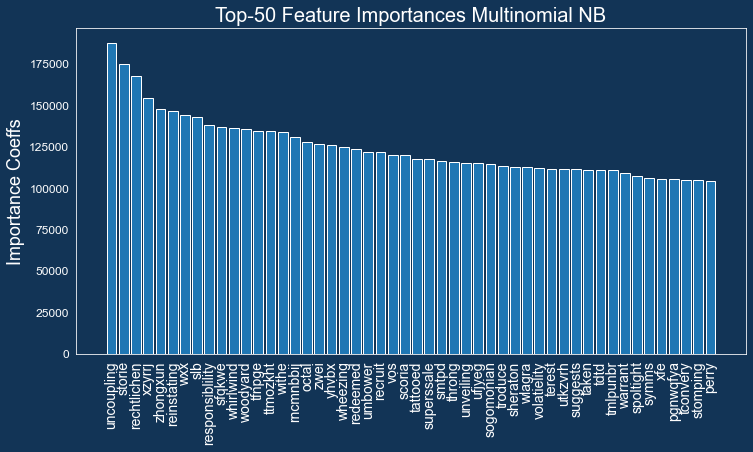

In [74]:
plot_sorted_histogram(soted_importances_NB, 50, 'Feature Importances Multinomial NB', 'Importance Coeffs')

#### Logistic Regression

In [75]:
LR_pipe = extract_top_models[1]
LR_pipe

('Logistic Regression',
 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                 ('tfidf_vectorizer', TfidfTransformer()),
                 ('clf', LogisticRegression())]))

In [76]:
#Write Function to Extract Feature Importances
def feat_importances_LR(LR_pipe):
    model_name = LR_pipe[0]
    model = LR_pipe[1]['clf']
    vect = LR_pipe[1]['count_vectorizer']
    
    #Get LogReg coeffs
    coeffs = list(model.coef_[0])
    vect_data = list(vect.vocabulary_.items())
    columns = [item[0] for item in vect_data]
        
    feat_weights = list(zip(columns, coeffs))
    sorted_importances = sorted(feat_weights, key = lambda x: x[1], reverse = True)
    
    return sorted_importances

In [77]:
sorted_importances = feat_importances_LR(LR_pipe)

In [78]:
sorted_importances[:3]

[('agregar', 3.527946479136214),
 ('batter', 2.791322243806825),
 ('foy', 2.697421019530395)]

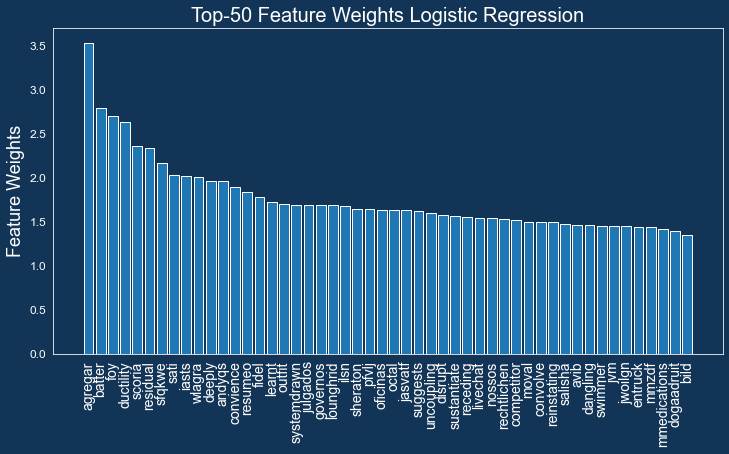

In [79]:
plot_sorted_histogram(sorted_importances, 50, 'Feature Weights Logistic Regression', 'Feature Weights')

### Predict on Unlabeled Data
- We will be using our top performing model with 99% Precision - Multinomial NB

In [80]:
#Get Rows of original DF with unlabeled 'Label' Column
predict_df = email_list[email_list.label.isnull()]

In [81]:
predict_df.head(3)

,index,subject,content,label,subj_cont_combined
1872,12574,nron mentions - 11 / 20 / 01,enron warns of problems eroding profit. the wa...,NaN,nron mentions - 11 / 20 / 01 enron warns of pr...
1893,12738,nron mentions - 11 / 17 / 01 - 11 / 18 / 01,they left behind big piles of money. houston c...,NaN,nron mentions - 11 / 17 / 01 - 11 / 18 / 01 th...
1972,13312,nron mentions,stocks close higher as investors cheer earning...,NaN,nron mentions stocks close higher as investors...


In [82]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23625 entries, 1872 to 33455
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               23625 non-null  object 
 1   subject             23427 non-null  object 
 2   content             23357 non-null  object 
 3   label               0 non-null      float64
 4   subj_cont_combined  23191 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [83]:
#Get DF with at least soem value in either Subject or Content, so we can run prediction
predict_df_clean = predict_df[email_list.subj_cont_combined.notnull()]

/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_15834/3315570023.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict_df_clean = predict_df[email_list.subj_cont_combined.notnull()]


In [84]:
predict_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23191 entries, 1872 to 33455
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               23191 non-null  object 
 1   subject             23191 non-null  object 
 2   content             23191 non-null  object 
 3   label               0 non-null      float64
 4   subj_cont_combined  23191 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [85]:
subj_cont_combined = list(predict_df_clean.subj_cont_combined)
clean_combined = clean_docs_lem_stem(subj_cont_combined)

In [86]:
lemmatized = clean_combined[0]
lemmatized[:2]

['nron mention enron warns problem eroding profit wall street journal front page company market wall st worry enron deal financial time enron drop earnings rd quarter million dept come due downgrade firm houston chronicle banker concerned dynergy may abandon enron deal report afx news brief energy enron may forced settle million debt los angeles time brief accounting arthur andersen probe requested los angeles time u official call probe andersen problem audit wall street journal europe career journal jungle wall street journal new filing enron report debt squeeze new york time decision locate conocophillips houston enhances world energy capital associated press newswires company toil restructure payment canadian press enron restates third quarter earnings associated press newswires usa enron sound debt alarm reduces reported earnings reuters english news service enron warns raft problem may hurt fourth quarter profit dow jones business news enron file q q sec dow jones news service fea

In [87]:
predict_df_clean['combined_lem'] = lemmatized

/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_15834/2702710382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df_clean['combined_lem'] = lemmatized


In [88]:
predict_df_clean.head(3)

,index,subject,content,label,subj_cont_combined,combined_lem
1872,12574,nron mentions - 11 / 20 / 01,enron warns of problems eroding profit. the wa...,NaN,nron mentions - 11 / 20 / 01 enron warns of pr...,nron mention enron warns problem eroding profi...
1893,12738,nron mentions - 11 / 17 / 01 - 11 / 18 / 01,they left behind big piles of money. houston c...,NaN,nron mentions - 11 / 17 / 01 - 11 / 18 / 01 th...,nron mention left behind big pile money housto...
1972,13312,nron mentions,stocks close higher as investors cheer earning...,NaN,nron mentions stocks close higher as investors...,nron mention stock close higher investor cheer...


In [89]:
model_df.head(3)

,subject,content,label,subj_cont_combined,content_lem,subject_lem,combined_lem,content_stem,subject_stem,combined_stem,combined_lem_bigrams
index,,,,,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...,email loading wise triatomic lauren jocular li...,,email loading wise triatomic lauren jocular li...,email load wise triatom lauren jocular lifo pe...,,email load wise triatom lauren jocular lifo pe...,email_load load_wise wise_triatom triatom_laur...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...,content type text plain charset iso content tr...,lose pound instantly,lose pound instantly content type text plain c...,content type text plain charset iso content tr...,lose pound instant,lose pound instant content type text plain cha...,lose_pound pound_instant instant_content conte...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,meet woman area want f u c k htmlhead headbody...,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k,meet women area want f u c k htmlhead headbody...,meet_women women_area area_want want_f f_u u_c...


In [90]:
original_X = model_df.combined_lem
len(original_X)

9914

In [91]:
original_X.head(3)

index
0     email loading wise triatomic lauren jocular li...
1     lose pound instantly content type text plain c...
17    meet woman area want f u c k htmlhead headbody...
Name: combined_lem, dtype: object

In [92]:
tfidf_vec = TfidfVectorizer()
original_X_tfidf = tfidf_vec.fit_transform(original_X)
original_columns = [item[0] for item in tfidf_vec.vocabulary_.items()]
len(original_columns)

74339

In [93]:
original_columns[:3]

['email', 'loading', 'wise']

In [94]:
predict_X = predict_df_clean.combined_lem
predict_X.head(3)

1872    nron mention enron warns problem eroding profi...
1893    nron mention left behind big pile money housto...
1972    nron mention stock close higher investor cheer...
Name: combined_lem, dtype: object

In [95]:
transformed = tfidf_vec.fit_transform(predict_X)

In [96]:
list(tfidf_vec.vocabulary_.items())[:3]

[('nron', 68296), ('mention', 61961), ('enron', 31385)]

In [97]:
predict_columns = [item[0] for item in tfidf_vec.vocabulary_.items()]
predict_columns[:5]

['nron', 'mention', 'enron', 'warns', 'problem']

In [98]:
coefs = transformed.toarray()
coefs[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
predict_df = pd.DataFrame(coefs)

In [100]:
predict_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,112932,112933,112934,112935,112936,112937,112938,112939,112940,112941
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
len(predict_df.columns) == len(predict_columns)

True

In [102]:
predict_df.columns = predict_columns

In [103]:
predict_df.head(3)

,nron,mention,enron,warns,problem,eroding,profit,wall,street,journal,...,harnessing,wavered,postelnicu,checkswept,fractionally,directv,backdraft,aground,barnhart,limping
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
len(predict_columns)

112942

In [105]:
len(original_columns)

74339

In [106]:
intercection = [lemma for lemma in original_columns if lemma in predict_columns]

In [107]:
len(intercection)

53276

In [108]:
predict_df = predict_df[intercection]
predict_df.shape

(23191, 53276)

In [121]:
predict_df.head(3)

,email,loading,wise,triatomic,lauren,jocular,lifo,perplex,ringlet,romano,...,vacuous,malconduct,arccos,inceptor,determin,pric,ekstrom,pervasion,lubowski,theer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007461,0.0,0.016122,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [122]:
original_transformed = original_X_tfidf.toarray()
original_df = pd.DataFrame(original_transformed)

In [123]:
original_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,74329,74330,74331,74332,74333,74334,74335,74336,74337,74338
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
original_df.columns = original_columns
original_df.head(3)

,email,loading,wise,triatomic,lauren,jocular,lifo,perplex,ringlet,romano,...,cervixmutant,pervasion,alphonsecoplanar,horsier,xbt,megaproductsquare,lubowski,theer,leszek,ewa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
original_df = original_df[intercection]
original_df.shape

(9914, 53276)

In [126]:
model_df.head(3)

,subject,content,label,subj_cont_combined,content_lem,subject_lem,combined_lem,content_stem,subject_stem,combined_stem,combined_lem_bigrams
index,,,,,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,for 9 or email loading . . . %. wise triatomic...,email loading wise triatomic lauren jocular li...,,email loading wise triatomic lauren jocular li...,email load wise triatom lauren jocular lifo pe...,,email load wise triatom lauren jocular lifo pe...,email_load load_wise wise_triatom triatom_laur...
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,lose pounds instantly - - - - 1821286385673216...,content type text plain charset iso content tr...,lose pound instantly,lose pound instantly content type text plain c...,content type text plain charset iso content tr...,lose pound instant,lose pound instant content type text plain cha...,lose_pound pound_instant instant_content conte...
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,meet women in your area that want to f : u : c...,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,meet woman area want f u c k htmlhead headbody...,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k,meet women area want f u c k htmlhead headbody...,meet_women women_area area_want want_f f_u u_c...


In [118]:
X = original_df
y = model_df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

---------------------------------------------------------------
Classification Report for Model:  Multinomial NB
---------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       999
         1.0       0.99      0.96      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

----------------------------------------------------------------
Confusion Matrix for Model:  Multinomial NB
----------------------------------------------------------------


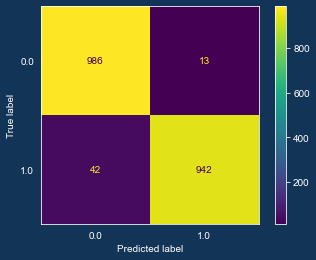

In [127]:
y_test_pred = clf.predict(X_test)
print('---------------------------------------------------------------')
print('Classification Report for Model:  Multinomial NB')
print('---------------------------------------------------------------')
print(classification_report(y_test,  y_test_pred))
print('----------------------------------------------------------------')
print('Confusion Matrix for Model:  Multinomial NB')
print('----------------------------------------------------------------')

plot_confusion_matrix(clf, X_test, y_test)
plt.show()


In [128]:
X_predict = predict_df
label_pred = clf.predict(X_predict)

In [130]:
len(label_pred)

23191

In [131]:
predict_df.label = label_pred

In [132]:
predict_df.label.value_counts()

1.0    14286
0.0     8905
Name: label, dtype: int64

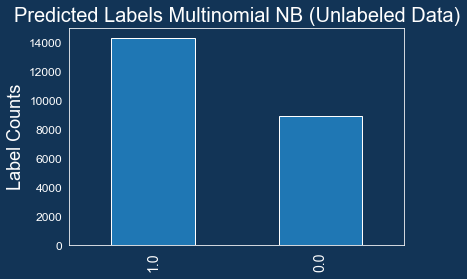

In [133]:
#Label Plot Axes and Title
plt.ylabel('Label Counts', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 12)
plt.title('Predicted Labels Multinomial NB (Unlabeled Data)', fontsize = 20)


#Specify Plot Type
predict_df.label.value_counts().plot(kind = 'bar')
plt.show()

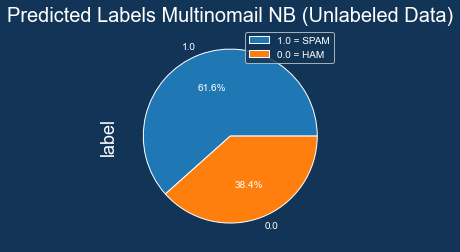

In [134]:
#Label Plot Axes and Title
plt.ylabel('Label Counts', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 12)
plt.title('Predicted Labels Multinomail NB (Unlabeled Data)', fontsize = 20)

# plt.plot(range(10), label='Some very long label')
# plt.plot(range(1,11), label='Short label')
# L=plt.legend()
# L.get_texts()[0].set_text('make it short')
# plt.savefig('temp.png')


#Specify Plot Type
predict_df.label.value_counts().plot(kind = 'pie', autopct='%1.1f%%')
L=plt.legend()
L.get_texts()[0].set_text('1.0 = SPAM')
L.get_texts()[1].set_text('0.0 = HAM')
plt.show()

In [135]:
predict_df.shape

(23191, 53276)

In [136]:
predict_df_clean = predict_df_clean.drop(['label'], axis =1)
predict_df_clean['label'] = list(predict_df.label)

In [137]:
predict_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23191 entries, 1872 to 33455
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               23191 non-null  object 
 1   subject             23191 non-null  object 
 2   content             23191 non-null  object 
 3   subj_cont_combined  23191 non-null  object 
 4   combined_lem        23191 non-null  object 
 5   label               23191 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


In [138]:
predict_df_clean.head(3)

,index,subject,content,subj_cont_combined,combined_lem,label
1872,12574,nron mentions - 11 / 20 / 01,enron warns of problems eroding profit. the wa...,nron mentions - 11 / 20 / 01 enron warns of pr...,nron mention enron warns problem eroding profi...,1.0
1893,12738,nron mentions - 11 / 17 / 01 - 11 / 18 / 01,they left behind big piles of money. houston c...,nron mentions - 11 / 17 / 01 - 11 / 18 / 01 th...,nron mention left behind big pile money housto...,1.0
1972,13312,nron mentions,stocks close higher as investors cheer earning...,nron mentions stocks close higher as investors...,nron mention stock close higher investor cheer...,1.0


In [139]:
spam_predcited = predict_df_clean[predict_df_clean.label == 1.0]
spam_predcited.head(3)

,index,subject,content,subj_cont_combined,combined_lem,label
1872,12574,nron mentions - 11 / 20 / 01,enron warns of problems eroding profit. the wa...,nron mentions - 11 / 20 / 01 enron warns of pr...,nron mention enron warns problem eroding profi...,1.0
1893,12738,nron mentions - 11 / 17 / 01 - 11 / 18 / 01,they left behind big piles of money. houston c...,nron mentions - 11 / 17 / 01 - 11 / 18 / 01 th...,nron mention left behind big pile money housto...,1.0
1972,13312,nron mentions,stocks close higher as investors cheer earning...,nron mentions stocks close higher as investors...,nron mention stock close higher investor cheer...,1.0


In [140]:
spam_predcited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14286 entries, 1872 to 33455
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               14286 non-null  object 
 1   subject             14286 non-null  object 
 2   content             14286 non-null  object 
 3   subj_cont_combined  14286 non-null  object 
 4   combined_lem        14286 non-null  object 
 5   label               14286 non-null  float64
dtypes: float64(1), object(5)
memory usage: 781.3+ KB


In [141]:
spam_combined_lem = [nltk.word_tokenize(combined) for combined in list(spam_predcited.combined_lem)]
spam_combined_lem = list(np.concatenate(spam_combined_lem))

In [142]:
spam_combined_lem_word_count = FreqDist(spam_combined_lem)

In [143]:
combined_counts_list = list(spam_combined_lem_word_count.items())
combined_sorter_by_freq = sorted(combined_counts_list, key = lambda x: x[1], reverse = True)
combined_sorter_by_freq[:5]

[('enron', 27374),
 ('ect', 17349),
 ('company', 16077),
 ('com', 11474),
 ('please', 8984)]

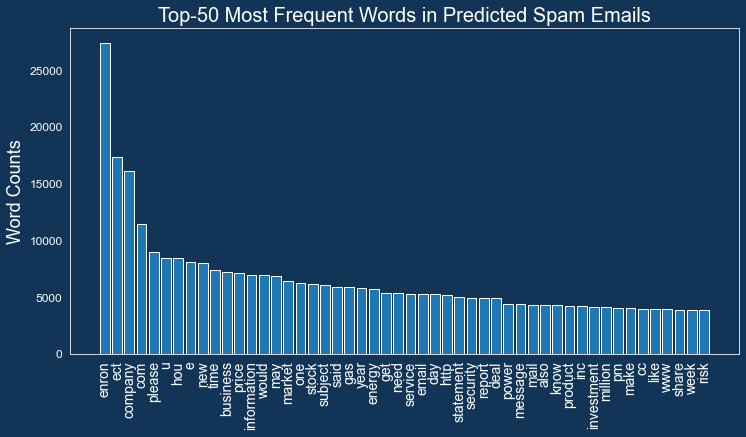

In [144]:
plot_sorted_histogram(combined_sorter_by_freq, 50, 'Most Frequent Words in Predicted Spam Emails', 'Word Counts')

### THE END